In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import urllib.request #web scraping

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\sas\AppData\Local\Continuum\anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.7.8                |           py37_0         3.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following packages will be UPDATED:

  conda                                        4.7.5-py37_0 --> 4.7.8-py37_0




conda-4.7.8          | 3.0 MB    |            |   0% 
conda-4.7.8          | 3.0 MB    | 7          |   7% 
conda-4.7.8          | 3.0 MB    | ##7        |  28% 
conda-4.7.8          | 3.0 MB    | #####1     |  52% 
conda-4.7.8          | 3.0 MB    | #######6   |  77% 
conda-4.7.8          | 3.0 MB    | #########7 |  98% 
conda-4.7.8          | 3.0 MB

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.


Libraries imported.


# Clustering Kansas City, MO neighborhoods by nonemergency city helpline (311 call) requests

## Sarah E. Smith

---

# 1. Introduction of the Problem and Description of the Data

Kansas City, Missouri is a medium sized city in the Midwestern United States. A regional arts hub, barbecue capitol and recent setting for "Queer Eye" on Netflix, the city is undergoing an economic renewal in its urban core. Strategic investment at the neighborhood level could help insure that prosperity increases for residents city-wide, while inprudent investment could exacerbate economic diparities across neighborhoods. One measure of neighborhood health especially relevant to City investment is the type and frequency of nonemergency city helpline ("311 call") requests. Available for download at OpenDataKC (https://data.kcmo.org/311/311-Call-Center-Service-Requests/7at3-sxhp), the 311 call database is a trove of over 1.3 million nonemergency calls from Kansas City residents, ranging from pothole reports and animal control requests to property violations (e.g. broken windows or peeling paint) and abandoned vehicles. The relative frequency of different types of calls in each neighborhood could give insight into whether there are special infrastructure or blight issues in certain areas. Clustering neighborhoods facing similar issues across the city (using K means clustering of 311 data) could allow city leaders to focus investment, and to develop neighborhood-cluster-level committees and task forces to adress pressing issues especially facing neighborhoods in a cluster. Finally, assessing the economic vibrancy of neighborhood clusters by frequncy of venues recorded in Foursquare could suggest which neighborhood clusters (and therefore which prominent nonemergency issues) are associated with decreased economic activity. For geographic visual context, I will map nighborhoods color-coded by cluster against a background of complete Kansas City metro area zipcodes (aquired by web scraping Statistical Atlas, https://statisticalatlas.com/metro-area/Missouri/Kansas-City/Overview , with latitude and logitude data pulled from the csv download OpenDataSoft: https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=MO&refine.state=KS).

---

# Methodology

---

## 2. Geographic Overview of Kansas City Metro area

### 2.1 Web scraping KC metro zipcodes from Statistical Atlas

First import Beautiful Soup, then scrape the html from the source page.

In [2]:
#import the Beautiful soup functions to parse the data returned from the Statistical Atlas website
import requests
from bs4 import BeautifulSoup
print("Soup imported")

Soup imported


In [3]:
url = "https://statisticalatlas.com/metro-area/Missouri/Kansas-City/Overview"
website = requests.get(url).text
soup = BeautifulSoup(website,'lxml')


The table containing zip codes is the 9th table of class 'info-table-contents-div' on the page.

In [4]:
right_table=soup.find_all('div', {'class':'info-table-contents-div'})[8]

zip_lst = [] 
for cell in right_table.findAll('a'):
    zip_lst.append(int(cell.find(text=True).strip('\n')))
zip_lst[:5]


[64001, 64011, 64012, 64014, 64015]

## Part 2.1 Merge metro Zip Code data with Latitude and Longitude 

I have downloaded data with US zipcodes, city, latitude and logitude information in csv format from OpenDataSoft:
https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=MO&refine.state=KS

In [5]:
coords = pd.read_csv(r'C:\Users\sas\Downloads\us-zip-code-latitude-and-longitude.csv')
coords.head()

,Zip;City;State;Latitude;Longitude;Timezone;Daylight savings time flag;geopoint
49654;Leland;MI;45.023384;-85.75697;-5;1;45.023384,-85.756970
50450;Lake Mills;IA;43.418877;-93.52078;-6;1;43.418877,-93.520780
52594;Unionville;IA;40.833045;-92.6867;-6;1;40.833045,-92.686700
54307;Green Bay;WI;44.460064;-88.007382;-6;1;44.460064,-88.007382
54812;Barron;WI;45.39701;-91.86337;-6;1;45.39701,-91.863370


In [6]:
coords.reset_index(inplace = True)
coords.columns = ['info', 'longitude']
coords.head()

,info,longitude
0,49654;Leland;MI;45.023384;-85.75697;-5;1;45.02...,-85.756970
1,50450;Lake Mills;IA;43.418877;-93.52078;-6;1;4...,-93.520780
2,52594;Unionville;IA;40.833045;-92.6867;-6;1;40...,-92.686700
3,54307;Green Bay;WI;44.460064;-88.007382;-6;1;4...,-88.007382
4,54812;Barron;WI;45.39701;-91.86337;-6;1;45.39701,-91.863370


Clean zip geographical data by splitting "info" column on ";", and only keep data for KC metro zipcodes

In [7]:
zips = []
cities = []
latitudes = []
longitudes = []

for index, row in coords.iterrows():
    info = row['info'].split(';')
    if int(info[0]) in zip_lst:
        zips.append(info[0])
        cities.append(info[1])
        latitudes.append(float(info[3]))
        longitudes.append(float(row['longitude']))
df_kcgeo = pd.DataFrame(zips,columns=['Zipcode'])
df_kcgeo['City'] = cities
df_kcgeo['Latitude'] = latitudes
df_kcgeo['Longitude'] = longitudes

df_kcgeo.head()

,Zipcode,City,Latitude,Longitude
0,64068,Liberty,39.246179,-94.41763
1,64722,Amoret,38.266148,-94.55686
2,64053,Independence,39.107845,-94.46556
3,64788,Urich,38.429061,-94.00494
4,64131,Kansas City,38.972473,-94.57656


## 2.2 Use Geolocator to find the center of Kansas City, and Folium to make a map of KC metro zipcodes

Start a new Geolocator user agent called "KCMO_ex" 

In [8]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [10]:
address = 'Kansas City, MO'

geolocator = Nominatim(user_agent="KCMO_ex")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kansas City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Kansas City are 39.100105, -94.5781416.


# Map of Kansas City Metro zipcodes

In [11]:
# create map of KC using latitude and longitude values
map_KC = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, label in zip(df_kcgeo['Latitude'], df_kcgeo['Longitude'], df_kcgeo['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_KC)  
    
map_KC

---

# Part 3. Kansas City nonemergency call data

## Part 3.1 Import and clean 311 call data 

Now that we have a good geographical overview of Kansas City, let's import Kansas City 311 data. 311 is the non-emergency service number to report problems such as potholes, building violations, and stray animals. This data comes from the city of Kansas City and is available for neighborhoods within the city limits. There are 1.35M rows of call data with 30 columns. The data set is available for download from OpenDataKC at: https://data.kcmo.org/311/311-Call-Center-Service-Requests/7at3-sxhp

In [12]:
problems = pd.read_csv(r'C:\Users\sas\Downloads\311_Call_Center_Service_Requests.csv')
problems.head()

,CASE ID,SOURCE,DEPARTMENT,WORK GROUP,REQUEST TYPE,CATEGORY,TYPE,DETAIL,CREATION DATE,CREATION TIME,CREATION MONTH,CREATION YEAR,STATUS,EXCEEDED EST TIMEFRAME,CLOSED DATE,CLOSED MONTH,CLOSED YEAR,DAYS TO CLOSE,STREET ADDRESS,ADDRESS WITH GEOCODE,ZIP CODE,NEIGHBORHOOD,COUNTY,COUNCIL DISTRICT,POLICE DISTRICT,PARCEL ID NO,LATITUDE,LONGITUDE,CASE URL,30-60-90 Days Open Window
0,2019001393,PHONE,Parks and Rec,Parks and Rec-Landscape Services-Forestry Tech,Trees-Services-Question,Trees,Services,Question,01/04/2019,10:29 AM,1,2019,RESOL,Y,01/17/2019,1.0,2019.0,13.0,2245 E 68th Ter,"2245 E 68th Ter64132\n(39.002433, -94.559166)",64132.0,Blenheim Square Research Hospital,Jackson,5.0,Metro,113845,39.002433,-94.559166,http://webfusion.kcmo.org/coldfusionapps/Actio...,NaN
1,2019054858,PHONE,NHS,NHS-Solid Waste-Abatement Referral,Trash / Recycling-Dumping-Solid Waste Referral,Trash / Recycling,Dumping,Solid Waste Referral,03/18/2019,11:47 AM,3,2019,RESOL,Y,04/15/2019,4.0,2019.0,28.0,7322 Forest Ave,"7322 Forest Ave64131\n(38.994319, -94.574714)",64131.0,East Meyer 6,Jackson,5.0,Metro,114805,38.994319,-94.574714,http://webfusion.kcmo.org/coldfusionapps/Actio...,NaN
2,2014123049,SYS,NHS,NHS-Neighborhood Preservation-,Property Violations,Property / Buildings / Construction,Property Maintenance,Main Structure,09/23/2014,10:23 AM,9,2014,RESOL,Y,06/25/2018,6.0,2018.0,1371.0,4717 NE 45TH TER,"4717 NE 45TH TER64117\n(39.175993, -94.523942)",64117.0,Winnwood,Clay,1.0,Shoal Creek,76031,39.175993,-94.523942,http://webfusion.kcmo.org/coldfusionapps/Actio...,NaN
3,2017101437,PHONE,NHS,NHS-Neighborhood Preservation-,Property Violations,Trash / Recycling,Nuisance,Trash on Private Property,08/10/2017,01:39 PM,8,2017,RESOL,Y,08/31/2018,8.0,2018.0,386.0,3819 E 9TH TER,"3819 E 9TH TER64127\n(39.100922, -94.536662)",64127.0,Lykins,Jackson,3.0,East,10040,39.100922,-94.536662,http://webfusion.kcmo.org/coldfusionapps/Actio...,NaN
4,2019003677,PHONE,Public Works,Public Works-Capital Projects-Traffic Control,Lights / Signals-Traffic Signal-New Signal Req...,Lights / Signals,Traffic Signal,New Signal Request,01/09/2019,05:29 PM,1,2019,RESOL,Y,01/15/2019,1.0,2019.0,6.0,11450 N Eastern Ave,"11450 N Eastern Ave64156\n(39.302408, -94.493208)",64156.0,Shoal Creek,Clay,1.0,Shoal Creek,98660,39.302408,-94.493208,http://webfusion.kcmo.org/coldfusionapps/Actio...,NaN


Clean the data by selecting only columns of interest, and renaming columns.

In [13]:
df_kc = problems.loc[:, ['ZIP CODE','CATEGORY', 'TYPE', 'REQUEST TYPE', 'NEIGHBORHOOD', 'LATITUDE', 'LONGITUDE']]
df_kc.columns = ['Zipcode','Category', 'Type', 'Request', 'Neighborhood','Latitude','Longitude']
df_kc.head()

,Zipcode,Category,Type,Request,Neighborhood,Latitude,Longitude
0,64132.0,Trees,Services,Trees-Services-Question,Blenheim Square Research Hospital,39.002433,-94.559166
1,64131.0,Trash / Recycling,Dumping,Trash / Recycling-Dumping-Solid Waste Referral,East Meyer 6,38.994319,-94.574714
2,64117.0,Property / Buildings / Construction,Property Maintenance,Property Violations,Winnwood,39.175993,-94.523942
3,64127.0,Trash / Recycling,Nuisance,Property Violations,Lykins,39.100922,-94.536662
4,64156.0,Lights / Signals,Traffic Signal,Lights / Signals-Traffic Signal-New Signal Req...,Shoal Creek,39.302408,-94.493208


## 3.2 Generate a dataframe with geographic information for each neighborhood, based on 311 data.
Neighborhoods are a more culturally relevant segmentation of geographic data, and are more granular, so I'll cluster by neighborhood rather than zipcode.


Group by Neighborhood from 311 data to get latitude and longitude for each neighborhood. 

In [14]:
kc_hoods = df_kc.groupby('Neighborhood').median()
kc_hoods.reset_index(inplace=True)

In [15]:
kc_hoods.head()

,Neighborhood,Zipcode,Latitude,Longitude
0,18th And Vine And Downtown Eas,64127.0,39.093559,-94.556567
1,18th And Vine And Downtown East,64127.0,39.093570,-94.556056
2,Antioch Acres,64117.0,39.177070,-94.548027
3,Armour Fields,64113.0,39.004117,-94.597883
4,Armour Hills,64113.0,39.004790,-94.588166


# Map of Kansas City MO neighborhoods in red and the metro area zipcodes in blue.

Neighborhoods are smaller and located within the city limits of Kansas City.

In [16]:
# create map of KC using latitude and longitude values
map_KC2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(kc_hoods['Latitude'], kc_hoods['Longitude'], kc_hoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_KC2)  
for lat, lng, label in zip(df_kcgeo['Latitude'], df_kcgeo['Longitude'], df_kcgeo['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_KC2)  
        
map_KC2


## 3.3 Preparing the 311 data for clustering

We want to cluster the neighborhoods based on the types of 311 calls. We need to use the more generic "Types" of requests because they are mostly clear of information (such as dispatch headquarters or transportation zone) that appears in the "Category" and "Request" fields. 

There is still some data cleaning to do, however. Let's group the data on "Type" to get the number of types, and list them. I'm grouping by "mode" to get the most common value in the text fields of "Category" and "Request" to get more insight into what the Types are, exactly.

In [18]:
prob_types = df_kc.groupby('Type').agg(pd.Series.mode)
print(prob_types.shape)
# prob_types Commented out for brevity

(288, 6)


The types "01", "02" ... "30" are all redundant, referring to dates for bulky item trash pickup. Let's replace all those values in df_kc with "Bulky Item Trash Pickup". The rest of the call Types look ok.

In [19]:
df_kc.loc[df_kc['Category'] ==  'Bulky Appointment', 'Type'] = "Bulky Item Trash Pickup"
prob_type_counts = df_kc.groupby('Type').count()
print(prob_type_counts.shape)
prob_type_counts.head(30)

(259, 6)


,Zipcode,Category,Request,Neighborhood,Latitude,Longitude
Type,,,,,,
311 Administration,105,105,105,104,105,105
ADA,43,43,43,42,43,43
ADA Accessibility,20,20,20,17,20,20
Abandoned,19016,19023,19023,18080,19023,19023
Abandoned On Street,12709,12709,12709,12660,12709,12709
Action Center,129,129,129,124,129,129
Administration,30400,30418,30418,28563,30418,30418
Airports,43,43,43,37,43,43
All,29017,29093,29093,26894,29093,29093


Now let's do one hot encoding on call Type and calculate frequencies to prepare for clustering.

In [20]:
# one hot encoding
onehot = pd.get_dummies(df_kc[['Type']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = df_kc['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Neighborhood,311 Administration,ADA,ADA Accessibility,Abandoned,Abandoned On Street,Action Center,Administration,Airports,All,Alley,Ambulance,Animal,Assessment Dispute,Athletics,Automatic Meter Reading,Banners,Barking Dog,Barrier Removal Program,Bicycle Pedestrian,Billing,Bite,Blvd / Pkwy,Board Up,Boulevards and Parkways,Broken Asphalt,Bruce R. Watkins Freeway,Brush,Building / Property,Bulky,Bulky Item Trash Pickup,Bulky Pick Up,Capital Improvement Management Office,Capital Projects Office,Care,Catch Basin,City,City Communications,City Manager‘s Office,City Property,Cleaning,Commercial Parking,Commercial Signs / Ads,Commercial Vehicle,Communicable Disease,Communications,Community Center,Community Service,Construction Issue/Concern,Construction Repair,Contractor,Contractor Restoration,Crack,Cruelty or Neglect,Culvert,Curb Box,Customer Service,Cut / Permit,DOWN OR DAMAGED,Damage,Damage / Dis-Repair,Dangerous Building,Data Not Available,Dead Animal,Disabled/Unlicensed on Private Property,Disease,Disease Control,Disrepair,Ditch,Dumping,Dumpsters,Early Set Out,Elevator Inspection,Emerald Ash,Emerald Ash Borer,Emergency,Emergency Management,Encroachment,Engineering,Facilities / Attractions,Fire,Flood Barricade,Food Establishment,Google Fiber Project,Graffiti,Guardrail,Hazardous,Hotel / Motel,Hydrant Repair,IT / Websites,Icing,Illegal Dumping,Illegally Parked,Illegally Parked Vehicle,Improved Channel,Industrial,Injury or Cruelty involving an Animal,Insect Problem,Inspection for NPD,Intersection,Investigation,Investigations,Jackson County,KC Police,Laboratory Service,Land Bank,Land Development,Land Trust,Land Use / Zoning Issue,Landlord Set Out,Landscape,Landscaping,Law,Lead Poisoning Prevention,Leaf & Brush,Leaf / Brush,Leak,MFS Referral (Meter Field Services),Maintenance,Malfunction,Manhole,Markings / Paint,Meter,Minor Home Repair,Missing,Municipal Court,NHS (Neighborhood Housing Services),Neighborhood Abatement Program,Neighborhood Preservation,New,New Request,No Dumping Sign,No Water / Pressure,Noise,Not Provided By KCMO,Nuisance,Obstructed / Closure,Other,Other-Maintenance,Outage,Outdoor Air Quality,Owned or Stray at Large,PIAC,Paint Program,Paper Street,Park Maintenance,Park Property,Parked on Unapproved Surface,Parking,Parking Lot,Parking Meter,Parking Ticket Issue,Parks,Parks Facilities,Pavement Restoration,Permit,Permit / License,Pipeline Barricade,Pipeline Referral,Pipeline Repair,Pipeline Restoration Concerns,Planning,Planting,Plate,Police,Pollutants,Pool / Hot Tub,Pothole,Priority,Private / Commercial,Private Property,Privately Owned Property,Property Maintenance,Public Facilities,Public Improvement Advisory Committee,Public Property,Public Restroom,Public Works,Quality,Questionable Activity,Railroad Property,Rat Control and Treatment,Rat Treatment,Recycle,Recycling,Referral,Regulated Industries,Removal,Repair,Replacement,Research,Restoration,Resurfacing,Return Call to Citizen,Revenue Protection,Right of Way,Right of Way (ROW),Rodent,Roll-out Cart,Salvage Yard Investigation,Scooter,Security / Safety,Services,Services (CPD),Services (NPD),Sewer,Sewer Backup / Leak,Sewer Odor,Sewer Referral,Sinkhole,Sinkhole Referral,Smoking / Tobacco,Snow / Ice,Solid Waste Operations,Speed Bump,Storm Clean Up,Storm Damage,Storm Drain / Catch Basin,Storm Water,Storm Water Referral,Stormwater Billing,Stray,Stray Confined,Street,Street Clean Up,Street Light,Street Name Signs,Street Preservation,Street Services,Street Sweeping,Street and Traffic,Streetlight Pole,Stump Removal,Supervisors,Ticket,Tobacco,Tow Services,Traffic Permit,Traffic Sign,Traffic Signal,Traffic Signs,Traffic Study,Trails,Transportation,Trash Cart,Trash Collection,Treatment,Trimming,Turf Restoration,Unapproved Objects,Valve Repair,Visibility,Volunteer Inspector Program,Walk In Center City Hall,Water,Water Billing,Water Main Repair,WaterServices-ConsumerServices-BackOfficeSupport,Weatherization Program,Wildlife
0,Blenheim Square Research Hospital,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [21]:
onehot.shape

(1338403, 260)

In [22]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
print(grouped.shape)
grouped.head()

(250, 260)


,Neighborhood,311 Administration,ADA,ADA Accessibility,Abandoned,Abandoned On Street,Action Center,Administration,Airports,All,Alley,Ambulance,Animal,Assessment Dispute,Athletics,Automatic Meter Reading,Banners,Barking Dog,Barrier Removal Program,Bicycle Pedestrian,Billing,Bite,Blvd / Pkwy,Board Up,Boulevards and Parkways,Broken Asphalt,Bruce R. Watkins Freeway,Brush,Building / Property,Bulky,Bulky Item Trash Pickup,Bulky Pick Up,Capital Improvement Management Office,Capital Projects Office,Care,Catch Basin,City,City Communications,City Manager‘s Office,City Property,Cleaning,Commercial Parking,Commercial Signs / Ads,Commercial Vehicle,Communicable Disease,Communications,Community Center,Community Service,Construction Issue/Concern,Construction Repair,Contractor,Contractor Restoration,Crack,Cruelty or Neglect,Culvert,Curb Box,Customer Service,Cut / Permit,DOWN OR DAMAGED,Damage,Damage / Dis-Repair,Dangerous Building,Data Not Available,Dead Animal,Disabled/Unlicensed on Private Property,Disease,Disease Control,Disrepair,Ditch,Dumping,Dumpsters,Early Set Out,Elevator Inspection,Emerald Ash,Emerald Ash Borer,Emergency,Emergency Management,Encroachment,Engineering,Facilities / Attractions,Fire,Flood Barricade,Food Establishment,Google Fiber Project,Graffiti,Guardrail,Hazardous,Hotel / Motel,Hydrant Repair,IT / Websites,Icing,Illegal Dumping,Illegally Parked,Illegally Parked Vehicle,Improved Channel,Industrial,Injury or Cruelty involving an Animal,Insect Problem,Inspection for NPD,Intersection,Investigation,Investigations,Jackson County,KC Police,Laboratory Service,Land Bank,Land Development,Land Trust,Land Use / Zoning Issue,Landlord Set Out,Landscape,Landscaping,Law,Lead Poisoning Prevention,Leaf & Brush,Leaf / Brush,Leak,MFS Referral (Meter Field Services),Maintenance,Malfunction,Manhole,Markings / Paint,Meter,Minor Home Repair,Missing,Municipal Court,NHS (Neighborhood Housing Services),Neighborhood Abatement Program,Neighborhood Preservation,New,New Request,No Dumping Sign,No Water / Pressure,Noise,Not Provided By KCMO,Nuisance,Obstructed / Closure,Other,Other-Maintenance,Outage,Outdoor Air Quality,Owned or Stray at Large,PIAC,Paint Program,Paper Street,Park Maintenance,Park Property,Parked on Unapproved Surface,Parking,Parking Lot,Parking Meter,Parking Ticket Issue,Parks,Parks Facilities,Pavement Restoration,Permit,Permit / License,Pipeline Barricade,Pipeline Referral,Pipeline Repair,Pipeline Restoration Concerns,Planning,Planting,Plate,Police,Pollutants,Pool / Hot Tub,Pothole,Priority,Private / Commercial,Private Property,Privately Owned Property,Property Maintenance,Public Facilities,Public Improvement Advisory Committee,Public Property,Public Restroom,Public Works,Quality,Questionable Activity,Railroad Property,Rat Control and Treatment,Rat Treatment,Recycle,Recycling,Referral,Regulated Industries,Removal,Repair,Replacement,Research,Restoration,Resurfacing,Return Call to Citizen,Revenue Protection,Right of Way,Right of Way (ROW),Rodent,Roll-out Cart,Salvage Yard Investigation,Scooter,Security / Safety,Services,Services (CPD),Services (NPD),Sewer,Sewer Backup / Leak,Sewer Odor,Sewer Referral,Sinkhole,Sinkhole Referral,Smoking / Tobacco,Snow / Ice,Solid Waste Operations,Speed Bump,Storm Clean Up,Storm Damage,Storm Drain / Catch Basin,Storm Water,Storm Water Referral,Stormwater Billing,Stray,Stray Confined,Street,Street Clean Up,Street Light,Street Name Signs,Street Preservation,Street Services,Street Sweeping,Street and Traffic,Streetlight Pole,Stump Removal,Supervisors,Ticket,Tobacco,Tow Services,Traffic Permit,Traffic Sign,Traffic Signal,Traffic Signs,Traffic Study,Trails,Transportation,Trash Cart,Trash Collection,Treatment,Trimming,Turf Restoration,Unapproved Objects,Valve Repair,Visibility,Volunteer Inspector Program,Walk In Center City Hall,Water,Water Billing,Water Main Repair,WaterServices-ConsumerServices-BackOfficeSupport,Weatherization Program,Wildlife
0,18th And Vine And Downtown Eas,0.000000,0.000000,0.0,0.024615,

---

# 4. Clustering Neighborhoods on 311 data

## 4.1 Do K means clustering with 6 clusters

In [23]:
# set number of clusters
kclusters = 6

clustering = grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([4, 0, 1, 0, 2, 1, 1, 2, 4, 2, 3, 1, 3, 2, 2, 4, 2, 1, 0, 2])

Add cluster labels to neighborhood

In [24]:
# add clustering labels

df_clusters = pd.DataFrame(kmeans.labels_,columns=['Cluster'])
df_clusters['Neighborhood'] = grouped ['Neighborhood']

#add latitude and longitude
df_clusters = pd.merge(df_clusters, kc_hoods, on='Neighborhood')
df_clusters.head()

,Cluster,Neighborhood,Zipcode,Latitude,Longitude
0,4,18th And Vine And Downtown Eas,64127.0,39.093559,-94.556567
1,0,18th And Vine And Downtown East,64127.0,39.093570,-94.556056
2,1,Antioch Acres,64117.0,39.177070,-94.548027
3,0,Armour Fields,64113.0,39.004117,-94.597883
4,2,Armour Hills,64113.0,39.004790,-94.588166


# Map KC neighborhoods with color coding based on cluster

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow[3] = ['#0ABF04']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clusters['Latitude'], df_clusters['Longitude'], df_clusters['Neighborhood'], df_clusters['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As a KC native, this map looks reasonable to me. 

---

# Results

---


# 5. Interpreting meaning from Neighborhood Clusters

## 5.1 Find the most frequent call types for each Cluster

Now let's find out what the most frequent 311 call Types are in each neighborhood cluster.


In [27]:
df_rankings = pd.merge(df_clusters[['Cluster','Neighborhood']], grouped, on='Neighborhood')
df_rankings = df_rankings.groupby('Cluster').mean()
df_rankings.reset_index(inplace = True)
df_rankings

,Cluster,311 Administration,ADA,ADA Accessibility,Abandoned,Abandoned On Street,Action Center,Administration,Airports,All,Alley,Ambulance,Animal,Assessment Dispute,Athletics,Automatic Meter Reading,Banners,Barking Dog,Barrier Removal Program,Bicycle Pedestrian,Billing,Bite,Blvd / Pkwy,Board Up,Boulevards and Parkways,Broken Asphalt,Bruce R. Watkins Freeway,Brush,Building / Property,Bulky,Bulky Item Trash Pickup,Bulky Pick Up,Capital Improvement Management Office,Capital Projects Office,Care,Catch Basin,City,City Communications,City Manager‘s Office,City Property,Cleaning,Commercial Parking,Commercial Signs / Ads,Commercial Vehicle,Communicable Disease,Communications,Community Center,Community Service,Construction Issue/Concern,Construction Repair,Contractor,Contractor Restoration,Crack,Cruelty or Neglect,Culvert,Curb Box,Customer Service,Cut / Permit,DOWN OR DAMAGED,Damage,Damage / Dis-Repair,Dangerous Building,Data Not Available,Dead Animal,Disabled/Unlicensed on Private Property,Disease,Disease Control,Disrepair,Ditch,Dumping,Dumpsters,Early Set Out,Elevator Inspection,Emerald Ash,Emerald Ash Borer,Emergency,Emergency Management,Encroachment,Engineering,Facilities / Attractions,Fire,Flood Barricade,Food Establishment,Google Fiber Project,Graffiti,Guardrail,Hazardous,Hotel / Motel,Hydrant Repair,IT / Websites,Icing,Illegal Dumping,Illegally Parked,Illegally Parked Vehicle,Improved Channel,Industrial,Injury or Cruelty involving an Animal,Insect Problem,Inspection for NPD,Intersection,Investigation,Investigations,Jackson County,KC Police,Laboratory Service,Land Bank,Land Development,Land Trust,Land Use / Zoning Issue,Landlord Set Out,Landscape,Landscaping,Law,Lead Poisoning Prevention,Leaf & Brush,Leaf / Brush,Leak,MFS Referral (Meter Field Services),Maintenance,Malfunction,Manhole,Markings / Paint,Meter,Minor Home Repair,Missing,Municipal Court,NHS (Neighborhood Housing Services),Neighborhood Abatement Program,Neighborhood Preservation,New,New Request,No Dumping Sign,No Water / Pressure,Noise,Not Provided By KCMO,Nuisance,Obstructed / Closure,Other,Other-Maintenance,Outage,Outdoor Air Quality,Owned or Stray at Large,PIAC,Paint Program,Paper Street,Park Maintenance,Park Property,Parked on Unapproved Surface,Parking,Parking Lot,Parking Meter,Parking Ticket Issue,Parks,Parks Facilities,Pavement Restoration,Permit,Permit / License,Pipeline Barricade,Pipeline Referral,Pipeline Repair,Pipeline Restoration Concerns,Planning,Planting,Plate,Police,Pollutants,Pool / Hot Tub,Pothole,Priority,Private / Commercial,Private Property,Privately Owned Property,Property Maintenance,Public Facilities,Public Improvement Advisory Committee,Public Property,Public Restroom,Public Works,Quality,Questionable Activity,Railroad Property,Rat Control and Treatment,Rat Treatment,Recycle,Recycling,Referral,Regulated Industries,Removal,Repair,Replacement,Research,Restoration,Resurfacing,Return Call to Citizen,Revenue Protection,Right of Way,Right of Way (ROW),Rodent,Roll-out Cart,Salvage Yard Investigation,Scooter,Security / Safety,Services,Services (CPD),Services (NPD),Sewer,Sewer Backup / Leak,Sewer Odor,Sewer Referral,Sinkhole,Sinkhole Referral,Smoking / Tobacco,Snow / Ice,Solid Waste Operations,Speed Bump,Storm Clean Up,Storm Damage,Storm Drain / Catch Basin,Storm Water,Storm Water Referral,Stormwater Billing,Stray,Stray Confined,Street,Street Clean Up,Street Light,Street Name Signs,Street Preservation,Street Services,Street Sweeping,Street and Traffic,Streetlight Pole,Stump Removal,Supervisors,Ticket,Tobacco,Tow Services,Traffic Permit,Traffic Sign,Traffic Signal,Traffic Signs,Traffic Study,Trails,Transportation,Trash Cart,Trash Collection,Treatment,Trimming,Turf Restoration,Unapproved Objects,Valve Repair,Visibility,Volunteer Inspector Program,Walk In Center City Hall,Water,Water Billing,Water Main Repair,WaterServices-ConsumerServices-BackOfficeSupport,Weatherization Program,Wildlife
0,0,0.000130,0.000167,0.000021,0.012764,0.008032,0.000149,0.017748,0.

In [28]:
num_top_issues = 5

#empty df
df_top_types = pd.DataFrame(columns=['Type','freq','Cluster'])

for cluster in df_rankings['Cluster']:
    #print("----"+ str(cluster)+"----")
    temp = df_rankings[df_rankings['Cluster'] == cluster].T.reset_index() #cut to single cluster and transpose df_rankings
    temp.columns = ['Type','freq']
    temp = temp.iloc[1:] #removing the first row, 'Cluster'
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp = temp.sort_values('freq', ascending=False).reset_index(drop=True)
    temp = temp.iloc[0:num_top_issues]
    temp['Cluster'] = cluster
    df_top_types = df_top_types.append(temp, sort=False, ignore_index = True)

df_top_types = df_top_types[['Cluster','freq', 'Type']]
df_top_types

,Cluster,freq,Type
0,0,0.05,Street
1,0,0.04,Pothole
2,0,0.04,Private Property
3,0,0.03,Removal
4,0,0.03,All
5,1,0.13,Private Property
6,1,0.04,Street
7,1,0.04,Trash Collection
8,1,0.04,Contractor
9,1,0.03,Property Maintenance


Above are the most frequent call types for each neighborhood cluster. It would be nice to get more detail about the 311 calls common in different clusters. We can get this information by finding the most common "Request" for each most common call "Type" in each neighborhood cluster.

## 5.2 Find most common Request for each most frequent Call Type in each cluster

In [29]:
#add cluster labels to df_kc
df_kc =  pd.merge(df_clusters[['Cluster','Neighborhood']], df_kc, on='Neighborhood')

df_kc.head()

,Cluster,Neighborhood,Zipcode,Category,Type,Request,Latitude,Longitude
0,4,18th And Vine And Downtown Eas,64108.0,Water Leak,Repair,Icing Caused by Water Leak,39.093570,-94.562463
1,4,18th And Vine And Downtown Eas,64127.0,Water Leak,All,Water Leak or Pressure Problem,39.092851,-94.559425
2,4,18th And Vine And Downtown Eas,64127.0,Snow & Ice,Street,Snow or Ice on Street (South of River to 47th ...,39.092768,-94.545667
3,4,18th And Vine And Downtown Eas,64127.0,Animal,Other,Animal Control,39.091537,-94.550808
4,4,18th And Vine And Downtown Eas,64127.0,Trash,City,Trash - Missed by City,39.095519,-94.545988


Get the most common Request for each call Type in each Cluster

In [30]:
top_request = df_kc.groupby(['Cluster','Type'])['Request'].agg(pd.Series.mode).to_frame().reset_index()


In [31]:
df_top_types = df_top_types.astype({'Cluster':int}, copy=True)
df_top_types = pd.merge(df_top_types, top_request, how = 'left', on=['Cluster','Type'])
df_top_types.head()


,Cluster,freq,Type,Request
0,0,0.05,Street,Pothole (South of 47th Street and West Of Blue...
1,0,0.04,Pothole,Streets / Roadways / Alleys-Pothole-District 3
2,0,0.04,Private Property,Property Violations
3,0,0.03,Removal,Tree Removal of a City Tree
4,0,0.03,All,Water Leak or Pressure Problem


# List of each Neighborhood Cluster with its map color, Freqency of the five most common call Types for the cluster, with the most common Request associated with the call Type for the cluster. Color coded Cluster map is plotted below for reference.

In [32]:
rainbow_names = ('Red', 'Purple', 'Blue','Turquoise', 'Green','Orange')
pd.set_option("display.width", 200)
for cluster in df_rankings['Cluster']:
    print('---------------------- Cluster '+str(cluster)+', '+rainbow_names[cluster]+' -------------------')
    print(df_top_types.loc[df_top_types['Cluster'] == cluster, ['freq','Type','Request']])
    print('\n')
    

---------------------- Cluster 0, Red -------------------
   freq              Type                                            Request
0  0.05            Street  Pothole (South of 47th Street and West Of Blue...
1  0.04           Pothole     Streets / Roadways / Alleys-Pothole-District 3
2  0.04  Private Property                                Property Violations
3  0.03           Removal                        Tree Removal of a City Tree
4  0.03               All                     Water Leak or Pressure Problem


---------------------- Cluster 1, Purple -------------------
   freq                  Type                                            Request
5  0.13      Private Property                                Property Violations
6  0.04                Street                   Snow or Ice on Street District 3
7  0.04      Trash Collection  Trash / Recycling-Trash Collection-Missed by C...
8  0.04            Contractor                       Trash - Missed by Contractor
9  0.03  Pro

In [33]:
map_clusters

## 5.3 Interpretation of Neighborhood Cluster features

A few telling features jump out of the neightborhood clusters and their most frequnt 311 calls: Cluster 5 (Orange) is a single neighborhood, "Central Blue Valley and Park Tower Gardens", bordering the river dealing with unique problems relating to water metering, leaks, and access; at least 60% of 311 calls in Cluster 5 were water-related. 

Cluster 3 (Turqouise), a broad swath of neighborhoods mostly in East Central Kansas City, is dealing with issues associated with blight including vacant buildings stray animals, as well as a high proportion (21%) of calls dealing with property violations (encompassing code and ordinance violations such as excessive wood rot or missing stair railings). 

Cluster 1 (Purple), consisting mostly of inner ring suburban neighborhoods in Southeast and Noth Central KC, is also dealing with an above average proportion of propety violations (13%), as well as issues with weekly trash pickup and snow/ice removal, problems also faced by Cluster 2 (Blue) which covers a similar geographic area but which has a lower frequency (7%) of property violations. 

Finally Cluster 0 (Red) and Cluster 4 (Green), are focused mostly in the midtown/downtown areas with some scattered suburban neighborhoods also included. Both have relatively distributed frequencies of 311 calls, suggesting that neighborhood issues are not focused in a single area, although Cluster 0 has a notably low frequency of property violations calls (5%) while Cluster 4 is more typical at 11%.

# 6. How is 311 call activity reflective of neghborhood economic activity, as measured by number and type of venues recorded on Foursquare?

## 6.1 Import Foursquare and get venues based on neighborhood cordinates, and clean Foursquare data.

Make a function to call Foursquare and get info for up to 200 venues in each neighborhood. I'm including the "icon prefix" info since we can parse out the broad venue categories like "food" or "park" from that.

In [34]:
#Make a function to call Foursquare and get info for up to 100 venues in each neighborhood. 
#I'm including the "icon prefix" info since we can parse out the broad venue categories like "food" or "park" from that.

def getNearbyVenues(zips, names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for zipcode, name, lat, lng in zip(zips, names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['icon']['prefix']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode',
                             'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category', 
                  'Icon']
    
    return(nearby_venues)

We'll use our kc_hoods dataframe, which has coordinates for each neighborhood, as a basis to make requests to Foursquare.

In [35]:
kc_hoods.head()

,Neighborhood,Zipcode,Latitude,Longitude
0,18th And Vine And Downtown Eas,64127.0,39.093559,-94.556567
1,18th And Vine And Downtown East,64127.0,39.093570,-94.556056
2,Antioch Acres,64117.0,39.177070,-94.548027
3,Armour Fields,64113.0,39.004117,-94.597883
4,Armour Hills,64113.0,39.004790,-94.588166


In [36]:
LIMIT = 200
KC_venues = getNearbyVenues(zips=kc_hoods['Zipcode'], 
                            names=kc_hoods['Neighborhood'],
                                   latitudes=kc_hoods['Latitude'],
                                   longitudes=kc_hoods['Longitude']
                                  )

In [37]:
print(KC_venues.shape)
KC_venues.head()

(3508, 9)


,Zipcode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Icon
0,64127.0,18th And Vine And Downtown Eas,39.093559,-94.556567,Arthur Bryant's Barbeque,39.091446,-94.556285,BBQ Joint,https://ss3.4sqi.net/img/categories_v2/food/bb...
1,64127.0,18th And Vine And Downtown Eas,39.093559,-94.556567,Negro Leagues Baseball Museum,39.091566,-94.562725,History Museum,https://ss3.4sqi.net/img/categories_v2/arts_en...
2,64127.0,18th And Vine And Downtown Eas,39.093559,-94.556567,Gates Bar-B-Q,39.098435,-94.555813,BBQ Joint,https://ss3.4sqi.net/img/categories_v2/food/bb...
3,64127.0,18th And Vine And Downtown Eas,39.093559,-94.556567,Blue Room,39.091344,-94.563187,Jazz Club,https://ss3.4sqi.net/img/categories_v2/arts_en...
4,64127.0,18th And Vine And Downtown Eas,39.093559,-94.556567,The Kansas City Juke House,39.091279,-94.561979,Lounge,https://ss3.4sqi.net/img/categories_v2/nightli...


Parse out the venue type and drop the icon column

In [42]:
KC_venues['Type'] = KC_venues['Icon'].str.split('/').str[5] 
KC_venues.drop("Icon", axis=1, inplace = True)
KC_venues.head()

,Zipcode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Type
0,64127.0,18th And Vine And Downtown Eas,39.093559,-94.556567,Arthur Bryant's Barbeque,39.091446,-94.556285,BBQ Joint,food
1,64127.0,18th And Vine And Downtown Eas,39.093559,-94.556567,Negro Leagues Baseball Museum,39.091566,-94.562725,History Museum,arts_entertainment
2,64127.0,18th And Vine And Downtown Eas,39.093559,-94.556567,Gates Bar-B-Q,39.098435,-94.555813,BBQ Joint,food
3,64127.0,18th And Vine And Downtown Eas,39.093559,-94.556567,Blue Room,39.091344,-94.563187,Jazz Club,arts_entertainment
4,64127.0,18th And Vine And Downtown Eas,39.093559,-94.556567,The Kansas City Juke House,39.091279,-94.561979,Lounge,nightlife


Now we have the venue info, including the Neighorhood, specific venue category, broad venue type, and geographical location. 

Let's check how many results we got for each neighborhood.

In [43]:
KC_venues.groupby('Neighborhood').count()


,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Type
Neighborhood,,,,,,,,
18th And Vine And Downtown Eas,29,29,29,29,29,29,29,29
18th And Vine And Downtown East,30,30,30,30,30,30,30,30
Antioch Acres,7,7,7,7,7,7,7,7
Armour Fields,13,13,13,13,13,13,13,13
Armour Hills,13,13,13,13,13,13,13,13
Ashland Ridge,11,11,11,11,11,11,11,11
Bannister Acres,3,3,3,3,3,3,3,3
Barry Harbour,2,2,2,2,2,2,2,2
Beacon Hills,16,16,16,16,16,16,16,16


## 6.2 Add cluster labels to venue data, and group venues by cluster

Adding Cluster lables to venues...

In [44]:
Labeled_venues = pd.merge(df_clusters, KC_venues, on='Neighborhood')
Labeled_venues.head()

,Cluster,Neighborhood,Zipcode_x,Latitude,Longitude,Zipcode_y,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Type
0,4,18th And Vine And Downtown Eas,64127.0,39.093559,-94.556567,64127.0,39.093559,-94.556567,Arthur Bryant's Barbeque,39.091446,-94.556285,BBQ Joint,food
1,4,18th And Vine And Downtown Eas,64127.0,39.093559,-94.556567,64127.0,39.093559,-94.556567,Negro Leagues Baseball Museum,39.091566,-94.562725,History Museum,arts_entertainment
2,4,18th And Vine And Downtown Eas,64127.0,39.093559,-94.556567,64127.0,39.093559,-94.556567,Gates Bar-B-Q,39.098435,-94.555813,BBQ Joint,food
3,4,18th And Vine And Downtown Eas,64127.0,39.093559,-94.556567,64127.0,39.093559,-94.556567,Blue Room,39.091344,-94.563187,Jazz Club,arts_entertainment
4,4,18th And Vine And Downtown Eas,64127.0,39.093559,-94.556567,64127.0,39.093559,-94.556567,The Kansas City Juke House,39.091279,-94.561979,Lounge,nightlife


Get total neighborhood counts per cluster

In [45]:
Neighborhood_counts = df_clusters.groupby('Cluster').count()
Neighborhood_counts = pd.DataFrame(Neighborhood_counts['Neighborhood'])
Neighborhood_counts

,Neighborhood
Cluster,
0,36
1,59
2,65
3,49
4,40
5,1


Get Venue counts by Type per Cluster

In [46]:
Venue_counts = Labeled_venues.groupby(['Cluster','Type']).count()
Venue_counts = pd.DataFrame(Venue_counts['Neighborhood'])
Venue_counts.head()

Neighborhood
Cluster Type                            
0       arts_entertainment           122
        building                      56
        education                      4
        food                         486
        nightlife                     85

In [47]:
Venue_counts = Venue_counts.rename(columns={'Neighborhood': 'Venue_Counts'})
Neighborhood_counts = Neighborhood_counts.rename(columns={'Neighborhood': 'Neighborhood_Counts'})

## 6.3 Make a heatmap of venue counts per neighborhood in each cluster, by venue type.

Building a grid of total venue counts of each type in each Cluster ...

In [48]:
Venue_counts = Venue_counts.unstack()
Venue_counts.columns = Venue_counts.columns.get_level_values(1)
Venue_counts

Type,arts_entertainment,building,education,event,food,nightlife,parks_outdoors,shops,travel
Cluster,,,,,,,,,
0,122.0,56.0,4.0,NaN,486.0,85.0,101.0,306.0,69.0
1,16.0,14.0,2.0,NaN,131.0,27.0,38.0,157.0,23.0
2,21.0,35.0,5.0,1.0,195.0,23.0,66.0,230.0,32.0
3,22.0,9.0,NaN,NaN,146.0,29.0,32.0,199.0,32.0
4,47.0,34.0,2.0,NaN,296.0,65.0,48.0,231.0,52.0
5,NaN,4.0,NaN,NaN,3.0,2.0,5.0,5.0,NaN


Normalizing to total neighborhood counts to get venue counts per Neighborhood of each type in each Cluster. 

In [50]:
Counts_per_hood = Venue_counts.div(Neighborhood_counts['Neighborhood_Counts'], axis=0)
Counts_per_hood.fillna(0, inplace=True)
Counts_per_hood

Type,arts_entertainment,building,education,event,food,nightlife,parks_outdoors,shops,travel
Cluster,,,,,,,,,
0,3.388889,1.555556,0.111111,0.000000,13.500000,2.361111,2.805556,8.500000,1.916667
1,0.271186,0.237288,0.033898,0.000000,2.220339,0.457627,0.644068,2.661017,0.389831
2,0.323077,0.538462,0.076923,0.015385,3.000000,0.353846,1.015385,3.538462,0.492308
3,0.448980,0.183673,0.000000,0.000000,2.979592,0.591837,0.653061,4.061224,0.653061
4,1.175000,0.850000,0.050000,0.000000,7.400000,1.625000,1.200000,5.775000,1.300000
5,0.000000,4.000000,0.000000,0.000000,3.000000,2.000000,5.000000,5.000000,0.000000


To get an overview of how venue frequency is distributed among neighborhood clusters, we can make a heat map.

# Heatmap of venue counts per neighborhood in each cluster, by venue type

To make it easier to interpret economic similarities among clusters, we'll include dendritic clustering by venue type frequencies in the heat map.

In [51]:
import seaborn as sns

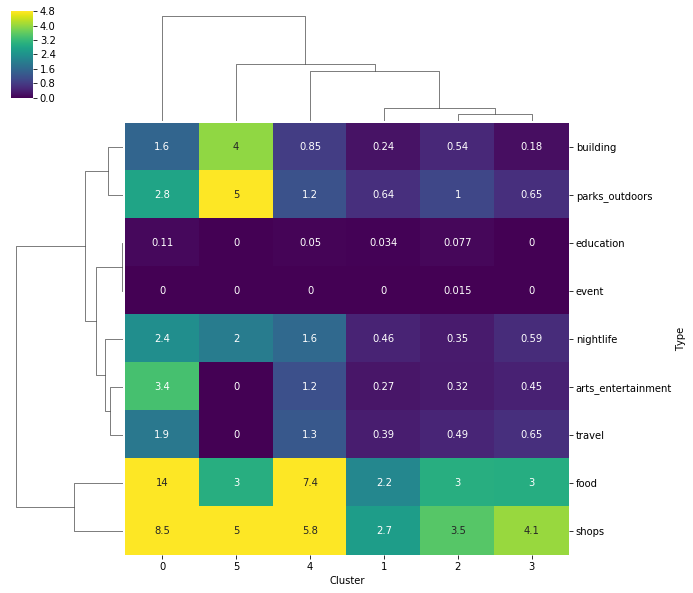

In [52]:
ax = sns.clustermap(Counts_per_hood.T, cmap = 'viridis',  vmax=4.8, annot=True, robust = True)

## 6.4 Interpration of venue data from clusters

Clearly, Clusters 4 and especially 0 are economic hubs, with restaurants/food and shops focused in those neighborhoods. It's notable that venues data groups Cluster 5 together with Clusters 0 and 4. It may be that if water issues were resolved, that neighborhood would group with those prosperous clusters.

Cluster 3, which also represents a cohort of neighborhoods that are geographically centrally located but facing issues of blight according to 311 data, also shows an above average frequency of shops but appears economically underserved in general.

---

# Discussion and Conclusions

---


# 7. Conclusions and Recommendations

### Neighborhood Clusters could assist in directing City funds toward problem areas, and provide a framework for building coalitions of neighborhoods facing similar issues to generate issue task forces and plans of action for addressing the issues Cluster-wide. 

Suggestions for City of Kansas City budget: The city may wish to prioritize addressing distinct infrastructure issues that are dominating 311 call frequencies in some clusters, such as water infrastructure issues in cluster 5, and weekly trash pickup in Clusters 1 and 2. 

When strategizing for long term economic investment, Cluster 3 neighborhoods should be prioritized. These are centrally located but facing issues of blight and low economic activity as measured by Foursquare venues. Traditionally, special investment districts have been outlined in braod strokes, with Troost St, the historic racial dividing line of the city, frequently demarcing the border of investment. It may be advantageous to the city to take a more granular neighborhood-by-neighborood approach and focus specifically on Cluster 3 neighborhoods. Suggested investment programs could include assistance with addressing proprty violations and vacant structures which are markedly prevalent in Cluster 3 neighborhoods.

Cluster 0 neighborhoods, which tend to be economically active and show few property violations, tend to be grouped geographically with Cluster 4 neighborhoods in the dowtown and midtown zones of Kansas City. However, there are a few geographic outliers which could be promising areas for economic development. The "Boulevard Village Cluster" neighborhood is on the East Side of KC, and adjacent to Cluster 3 neighborhoods. Investment in the "Boulevard Village Cluster" neighborhood could prove especially effective in increasing access to services for Cluster 3 neighborhood residents, and seed the expansion of economic activity in that region.